## Key Takeaways

### For NNs using Images
- Convolutions are helpful
- SGD isn't as good as newer optimizers like Adam and NesterovAdam - https://towardsdatascience.com/types-of-optimization-algorithms-used-in-neural-networks-and-ways-to-optimize-gradient-95ae5d39529f
- normalization is helpful (both of the features and the output) and helps prevent divergence
- batch normalization works well after the activation https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md


### Generally
- Never trust the data blindly

## Setup

### Imports

In [27]:
%matplotlib inline
from pandas.io.parsers import read_csv
from sklearn.model_selection import train_test_split

import os
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping, Callback, History

from tensorflow.python.client import device_lib

from augmentdata.CustImageDataGenerator import CustImageDataGenerator,CustNumpyArrayIterator

print(device_lib.list_local_devices()) # confirm using GPU

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5090030199252051755
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 144677273
locality {
  bus_id: 1
}
incarnation: 3676832405386477330
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


### Constants

In [2]:
TRAIN_DATA = '../data/training.csv'
TEST_DATA = '../data/test.csv'
IMAGE_ROWS = 96
IMAGE_COLS = 96
INPUT_SHAPE = (IMAGE_ROWS, IMAGE_COLS, 1)

### Load the Data

In [3]:
def loader(test=False, seed=None, keeplabels=None):
    if seed:
        np.random.seed(seed)
    fileloc = TEST_DATA if test else TRAIN_DATA
    
    df = read_csv(fileloc)
    
    df['Image'] = df['Image'].apply(lambda x: np.fromstring(x, sep=' '))
    
    if keeplabels:
        df = df[list(keeplabels) + ['Image']]
        
    df = df.dropna() # drop rows with missing labels
    
    X = np.vstack(df['Image'])
    # by pixel across the whole dataset subtract mean and divide by stdev
    X = X - np.tile(np.mean(X,axis=0),(X.shape[0],1))
    X = X / np.tile(np.std(X,axis=0),(X.shape[0],1))
    X = X.astype(np.float32)
    
    if not test:
        y = df[df.columns.difference(['Image'])].values
        y = y.astype(np.float32)
        y = (y - 48) / 48 # this helps, but tanh on output doesnt
        shuffle = np.random.permutation(np.arange(X.shape[0]))
        X, y = X[shuffle], y[shuffle]
    else:
        y = None
    
    X = X.reshape(-1, 96, 96, 1)

    return X, y, df.columns.difference(['Image'])


In [4]:
X, y, labels = loader(seed=42)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        random_state=42)
data=[X_train, X_test, y_train, y_test]

### Plot an Example Image

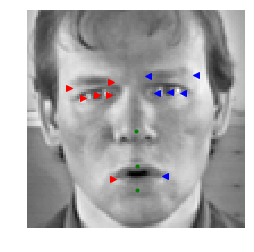

In [5]:
def plot_image(image, points, labels=list(labels)):
    """Helper function to plot images"""
    plt.figure(figsize=(4,4))
    plt.imshow(np.reshape(image,(96,96)), cmap = 'gray')
    x = 0
    for i, label in enumerate(labels):
        if label[-1]=='x':
            x = points[i]
        else:
            if label in ['left_eye_center_y',
                         'left_eye_inner_corner_y', 
                         'left_eye_outer_corner_y', 
                         'left_eyebrow_inner_end_y', 
                         'left_eyebrow_outer_end_y',
                         'mouth_left_corner_y'
                        ]:
                plt.plot(x, points[i], 'b<')
            elif label in ['right_eye_center_y',
                         'right_eye_inner_corner_y', 
                         'right_eye_outer_corner_y', 
                         'right_eyebrow_inner_end_y', 
                         'right_eyebrow_outer_end_y',
                          'mouth_right_corner_y']:
                plt.plot(x, points[i], 'r>')
            else:
                plt.plot(x, points[i],'g.')
    plt.axis('off')



plot_image(X_train[0], 48*y_train[0]+48, labels)


### Model Fitting Function

In [6]:
def fit_model(model, data, epochs=1000, patience=100):
    X_train = data[0]
    X_test = data[1]
    y_train = data[2]
    y_test = data[3]
    model.compile(loss='mse', optimizer=Nadam())
    earlystop = EarlyStopping(monitor='loss',
                             patience=patience,
                             verbose=1,
                             mode="auto")
    callbacks = [earlystop]
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=32,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test)
             )
    return history

### Helper function to plot the loss

In [7]:
def plot_loss(hists, names):
    colordict = {
        0 : 'b',
        1 : 'g',
        2 : 'r'
    }
    
    for i, hist in enumerate(hists):
        plt.plot([np.sqrt(x) * 48 for x in hist.history['loss']],
                 color=colordict[i],
                 label="train " + names[i])
        plt.plot([np.sqrt(x) * 48 for x in hist.history['val_loss']],
                 color=colordict[i],
                 linestyle='dashed',
                 label="valid " + names[i])
        plt.grid()
        plt.legend()
        plt.xlabel("epoch")
        plt.ylabel("RMSE")
        plt.yscale("log")
    plt.show()

## Models 
### 1 Dense Hidden Layer with 100 units

In [8]:
model1 = Sequential()
model1.add(Flatten(input_shape=INPUT_SHAPE))
model1.add(Dense(100, activation='relu'))
model1.add(Dense(30))
print(model1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               921700    
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
Total params: 924,730
Trainable params: 924,730
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
model1_hist = fit_model(model1,data,epochs=1000,patience=10)

Train on 1712 samples, validate on 428 samples
Epoch 1/1000
1712/1712 [==============================] - 1s 713us/step - loss: 18.6602 - val_loss: 3.0055
Epoch 2/1000
1712/1712 [==============================] - 0s 195us/step - loss: 9.9308 - val_loss: 4.1882
Epoch 3/1000
1712/1712 [==============================] - 0s 213us/step - loss: 1.4038 - val_loss: 3.1449
Epoch 4/1000
1712/1712 [==============================] - 0s 187us/step - loss: 10.7696 - val_loss: 1.3008
Epoch 5/1000
1712/1712 [==============================] - 0s 194us/step - loss: 6.9898 - val_loss: 1.4946
Epoch 6/1000
1712/1712 [==============================] - 0s 197us/step - loss: 0.6708 - val_loss: 0.4685
Epoch 7/1000
1712/1712 [==============================] - 0s 191us/step - loss: 0.6334 - val_loss: 0.5065
Epoch 8/1000
1712/1712 [==============================] - 0s 196us/step - loss: 0.2702 - val_loss: 0.3307
Epoch 9/1000
1712/1712 [==============================] - 0s 203us/step - loss: 0.2840 - val_loss: 0.29

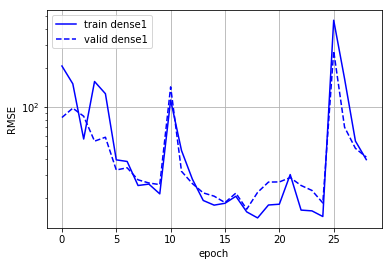

In [10]:
plot_loss([model1_hist],['dense1'])

In [11]:
model1BN = Sequential()
model1BN.add(Flatten(input_shape=INPUT_SHAPE))
model1BN.add(Dense(100, activation='relu'))
model1BN.add(BatchNormalization())
model1BN.add(Dense(30))
print(model1BN.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               921700    
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_4 (Dense)              (None, 30)                3030      
Total params: 925,130
Trainable params: 924,930
Non-trainable params: 200
_________________________________________________________________
None


Train on 1712 samples, validate on 428 samples
Epoch 1/1000
1712/1712 [==============================] - 1s 399us/step - loss: 0.3524 - val_loss: 0.0636
Epoch 2/1000
1712/1712 [==============================] - 0s 246us/step - loss: 0.0217 - val_loss: 0.0192
Epoch 3/1000
1712/1712 [==============================] - 0s 268us/step - loss: 0.0101 - val_loss: 0.0101
Epoch 4/1000
1712/1712 [==============================] - 0s 239us/step - loss: 0.0070 - val_loss: 0.0076
Epoch 5/1000
1712/1712 [==============================] - 0s 258us/step - loss: 0.0051 - val_loss: 0.0053
Epoch 6/1000
1712/1712 [==============================] - 1s 313us/step - loss: 0.0044 - val_loss: 0.0076
Epoch 7/1000
1712/1712 [==============================] - 1s 310us/step - loss: 0.0039 - val_loss: 0.0045
Epoch 8/1000
1712/1712 [==============================] - 0s 274us/step - loss: 0.0032 - val_loss: 0.0043
Epoch 9/1000
1712/1712 [==============================] - 0s 252us/step - loss: 0.0029 - val_loss: 0.0057

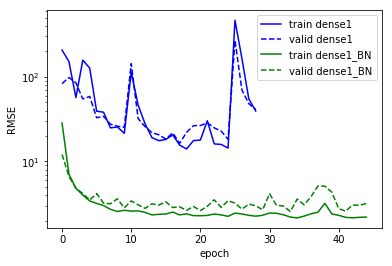

In [12]:
model1BN_hist = fit_model(model1BN,data,epochs=1000,patience=10)
plot_loss([model1_hist,model1BN_hist],['dense1','dense1_BN'])

### Model with convolutions

In [17]:
model2 = Sequential()
model2.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                input_shape=INPUT_SHAPE))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(filters=64,
                 kernel_size=(2, 2),
                 activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(filters=128,
                 kernel_size=(2, 2),
                 activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Flatten())
model2.add(Dense(500, activation = "relu"))
model2.add(BatchNormalization())
model2.add(Dense(100, activation = "relu"))
model2.add(BatchNormalization())
model2.add(Dense(30))
print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
batch_normalization_5 (Batch (None, 94, 94, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 46, 46, 64)        8256      
_________________________________________________________________
batch_normalization_6 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 22, 128)       32896     
__________

In [18]:
model2_hist = fit_model(model2,data,epochs=1000,patience=100)


Train on 1712 samples, validate on 428 samples
Epoch 1/100
1712/1712 [==============================] - 4s 2ms/step - loss: 0.2411 - val_loss: 0.0944
Epoch 2/100
1712/1712 [==============================] - 3s 2ms/step - loss: 0.0147 - val_loss: 0.0505
Epoch 3/100
1712/1712 [==============================] - 3s 2ms/step - loss: 0.0074 - val_loss: 0.0177
Epoch 4/100
1712/1712 [==============================] - 3s 2ms/step - loss: 0.0056 - val_loss: 0.0120
Epoch 5/100
1712/1712 [==============================] - 3s 2ms/step - loss: 0.0049 - val_loss: 0.0066
Epoch 6/100
1712/1712 [==============================] - 3s 2ms/step - loss: 0.0045 - val_loss: 0.0067
Epoch 7/100
1712/1712 [==============================] - 3s 2ms/step - loss: 0.0041 - val_loss: 0.0070
Epoch 8/100
1712/1712 [==============================] - 3s 2ms/step - loss: 0.0039 - val_loss: 0.0076
Epoch 9/100
1712/1712 [==============================] - 3s 2ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 10/100
1712/1712 [==

1712/1712 [==============================] - 3s 2ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 80/100
1712/1712 [==============================] - 3s 1ms/step - loss: 0.0012 - val_loss: 0.0042
Epoch 81/100
1712/1712 [==============================] - 3s 2ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 82/100
1712/1712 [==============================] - 3s 2ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 83/100
1712/1712 [==============================] - 3s 2ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 84/100
1712/1712 [==============================] - 3s 2ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 85/100
1712/1712 [==============================] - 3s 2ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 86/100
1712/1712 [==============================] - 3s 2ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 87/100
1712/1712 [==============================] - 3s 2ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 88/100
1712/1712 [==============================] - 3s 2ms/step - loss:

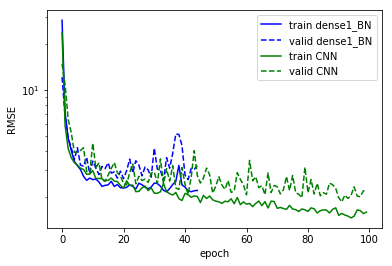

In [19]:
plot_loss([model1BN_hist, model2_hist],['dense1_BN','CNN'])

### Use the custom generator to enhance the training data

In [38]:
datagen = CustImageDataGenerator(
    rotation_range=5. #degrees
     ,horizontal_flip=True
     ,width_shift_range=.05 # percent of image width
     ,height_shift_range=.05 # percent of image height
    ,zoom_range=(.95,1.05) # <1 means zoom in, >1 means zoom out
    ).flow(X_train,y_train,whichlabels=list(labels), batch_size=batch)
def fit_model_gen(model, generator=datagen, data=data, epochs=100, patience=10):
    X_valid = data[1]
    y_valid = data[3]
    model.compile(loss='mse', optimizer=Nadam())
    earlystop = EarlyStopping(monitor='loss',
                             patience=patience,
                             verbose=1,
                             mode="auto")
    callbacks = [earlystop]
    history = model.fit_generator(generator,
                        epochs=epochs,
                        steps_per_epoch=data[0].shape[0]//32,
                        callbacks=callbacks,
                        validation_data=(X_valid, y_valid)
             )
    return history

In [39]:
model2_augmented_hist = fit_model_gen(model2,datagen, data,epochs=1000,patience=100)

Epoch 1/1000
53/53 [==============================] - 3s 65ms/step - loss: 0.0078 - val_loss: 0.0047
Epoch 2/1000
53/53 [==============================] - 2s 34ms/step - loss: 0.0077 - val_loss: 0.0038
Epoch 3/1000
53/53 [==============================] - 2s 33ms/step - loss: 0.0143 - val_loss: 0.0082
Epoch 4/1000
53/53 [==============================] - 2s 34ms/step - loss: 0.0076 - val_loss: 0.0045
Epoch 5/1000
53/53 [==============================] - 2s 34ms/step - loss: 0.0072 - val_loss: 0.0025
Epoch 6/1000
53/53 [==============================] - 2s 34ms/step - loss: 0.0066 - val_loss: 0.0033
Epoch 7/1000
53/53 [==============================] - 2s 34ms/step - loss: 0.0060 - val_loss: 0.0036
Epoch 8/1000
53/53 [==============================] - 2s 34ms/step - loss: 0.0072 - val_loss: 0.0023
Epoch 9/1000
53/53 [==============================] - 2s 34ms/step - loss: 0.0058 - val_loss: 0.0046
Epoch 10/1000
53/53 [==============================] - 2s 35ms/step - loss: 0.0063 - val_lo

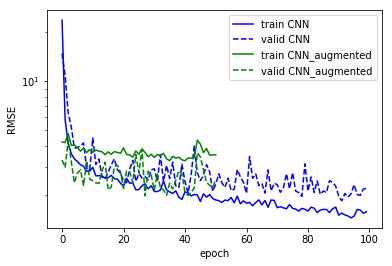

In [40]:
plot_loss([model2_hist, model2_augmented_hist],['CNN','CNN_augmented'])

## Create Predictions
### Load the Testing Time Images

In [51]:
out_images, _ , _ = loader(test=True, seed=None, keeplabels=None)


### Create the Preditions

In [53]:
final_model = 


(1783, 96, 96, 1)


In [ ]:
keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)

keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid',
                    data_format=None, dilation_rate=(1, 1), activation=None,
                    use_bias=True, kernel_initializer='glorot_uniform',
                    bias_initializer='zeros', kernel_regularizer=None,
                    bias_regularizer=None, activity_regularizer=None,
                    kernel_constraint=None, bias_constraint=None)

keras.layers.Dense(units, activation=None, use_bias=True, 
                   kernel_initializer='glorot_uniform', 
                   bias_initializer='zeros', kernel_regularizer=None, 
                   bias_regularizer=None, activity_regularizer=None, 
                   kernel_constraint=None, bias_constraint=None)

keras.layers.Dropout(rate, noise_shape=None, seed=None)
